In [3]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [4]:
def ntdd(ensayos, ventana=0.2, paso=0.01, tiempo_i=-2, tiempo_f=4, z="n", m=0, d=1):
    """
    Función realizada por Daniel Suárez
    Esta función muestra la gráfica de la tasa de disparo de un conjunto de ensayos de un archivo según indique el usuario.

    La función tiene 9 parámetros, 2 opcionales:
    1. ensayos: Es el archivo que contiene los ensayos con los tiempos en los que se dieron los registros de los potenciales de acción.
    2. ventana: Es la longitud (en segundos) de una ventana causal y cuadrada sobre la cual se contarán los registros.
    3. paso: Es el tiempo (en segundos) por el cual se desplazará nuestra ventana.
    4. color: Es el color de la gráfica.
    5. nombre: Nombre del archivo que irá en la etiqueta de la gráfica
    6. tiempo_i (opcional): Es el tiempo (en segundos) a partir del cual se comienzan a realizar los registros.
    7. tiempo_f (opcional): Es el tiempo (en segundos) final considerado para tomar los registros.
    """
    frecuencias_de_disparo=[[] for i in range(len(ensayos))] #Generamos una lista de listas vacías del tamaño del número de ensayos que abarquemos
    for i in range(len(ensayos)): #Iteramos sobre el número de ensayos
        ensayo=ensayos[i]
        limite_i=tiempo_i #Definimos el limite inicial del primer intervalo
        limite_f=tiempo_i+ventana #Definimos el límite final del primer intervalo
        while limite_f<=tiempo_f: #Ciclamos mientras el límite final de los intervalos no alcancé el límite final de tiempo del documento
            potenciales=np.array(ensayo>=limite_i) & np.array(ensayo<=limite_f) #Contamos el número de potenciales según cumplan la condición de encontrarse entre los valores límites del intervalo
            frecuencias_de_disparo[i].append(len(ensayo[potenciales])) #Añadimos a una de nuestras listas generadas previamente el valor de potenciales contados por intervalo
            limite_i+=paso #Añadimos a ambos límites el valor del paso
            limite_f+=paso
    tdd=np.array(frecuencias_de_disparo)/ventana
    t=np.linspace(tiempo_i+ventana, tiempo_f+paso, len(tdd[0]))
    if z=="e":
        tdd=tdd*ventana
        return tdd, t
    if z=="t":
        z=(tdd-np.mean(tdd))/np.std(tdd)
        return z, t
    elif z=="g":
        return np.mean(tdd), np.std(tdd)
    elif z=="b":
        z=(tdd-m)/d
        return z, t
    elif z=="v" or z=="c": #En el caso de escoger "c" el usuario debe considerar separar por clases a la hora de llamar la función
        z=(tdd-np.mean(tdd, axis=0))/np.std(tdd, axis=0)
        return z, t
    else:
        return tdd, t

In [5]:
procesadas = "D:\\Figure S5 Fix"

In [6]:
sesiones_VPC = os.listdir(os.path.join(procesadas, "Processed"))
psico_VPC=[]
PUxneurona=[]
clasesxneurona_VPC=[]
aciertosxneurona_VPC=[]
neuronas_VPC=[]
neu_x_sesion_VPC=np.zeros(len(sesiones_VPC)+1)

In [7]:
nums=[]
nombres_neuronas=[]
neuxsesxelec_VPC = []
for total, i in enumerate(sesiones_VPC): 
    sesion = os.path.join(procesadas, "Processed", i)
    electrodos = os.listdir(sesion)[:-1]
    psico=np.loadtxt(os.path.join(sesion, os.listdir(sesion)[-1]), delimiter=",", skiprows=1, usecols=(1, 4, 26))
    psico_VPC.append(psico)
    neu_x_elec = np.zeros(len(electrodos))
    for num_elec, j in enumerate(electrodos):
        electrodo = os.path.join(sesion, j, "sorted_neurons")
        if os.path.exists(electrodo)==True:
            archivos_neuronas = [os.path.basename(f) for f in glob.glob(os.path.join(electrodo, "ne*.csv"))]
            neu_x_elec[num_elec] = len(archivos_neuronas)
            for k in archivos_neuronas:
                conteo_orden=0
                en_es_cl=np.loadtxt(os.path.join(electrodo, k), delimiter=",", skiprows=1)
                ensayos=np.array(np.unique(en_es_cl[:, 0]), dtype=np.int64)
                ensayos_limpios=[]
                clases=np.zeros(len(ensayos))
                aciertos=np.zeros(len(ensayos))
                numero_en=len(ensayos)
                nums.append(numero_en)
                nombres_neuronas.append([electrodo, k])
                for idx, l in enumerate(ensayos):
                    conteo_orden+=1
                    if l==conteo_orden:
                        espigas=en_es_cl[np.where(en_es_cl[:, 0]==l)].T
                        ensayo=espigas[1, :]
                    if len(ensayo)!=0:
                        clases[idx]=psico[l-1, 0]
                        aciertos[idx]=psico[l-1, 1]
                        ensayos_limpios.append(ensayo)
                    else:
                        ensayos_limpios.append(np.array([-7]))
                neuronas_VPC.append(ensayos_limpios)
                clasesxneurona_VPC.append(clases)
                aciertosxneurona_VPC.append(aciertos)
    neu_x_sesion_VPC[total+1]=len(clasesxneurona_VPC)
    neuxsesxelec_VPC.append(neu_x_elec)

In [8]:
tasas_de_disparo_VPC=[]
for i in neuronas_VPC:
    tasa_de_neurona, t=ntdd(i)
    tasas_de_disparo_VPC.append(tasa_de_neurona)

In [9]:
color_tactil = "#15367D"
col = ["#CC7400", "#8FB032", "#7D3E94"]
PU = 2.5 

In [10]:
indice = 0
neurona = neuronas_VPC[indice]
bloques = []
ensayos_sn = []
for i in [6, 7, 8, 9, 10, 5, 4, 3, 2, 1]:
    if i >= 6 and i <= 10:
        idx_sn = np.where((clasesxneurona_VPC[indice] == i) & (aciertosxneurona_VPC[indice] == 1))[0]
        if len(idx_sn) < 7:
            idx_sn_err = np.where((clasesxneurona_VPC[indice] == i) & (aciertosxneurona_VPC[indice] == 0))[0]
            idx_sn = np.concatenate((idx_sn, idx_sn_err))
            idx_sn = idx_sn[:7]
        else:
            idx_sn = idx_sn[:7]
        for j in idx_sn:
            ensayos_sn.append(neurona[j])
        if i == 10:
            bloques.append(ensayos_sn)
    else:
        ensayos_tac = []
        idx_sn = np.where((clasesxneurona_VPC[indice] == i) & (aciertosxneurona_VPC[indice] == 1))[0]
        if len(idx_sn) < 7:
            idx_sn_err = np.where((clasesxneurona_VPC[indice] == i) & (aciertosxneurona_VPC[indice] == 0))[0]
            idx_sn = np.concatenate((idx_sn, idx_sn_err))
            idx_sn = idx_sn[:7]
        else:
            idx_sn = idx_sn[:7]
        for j in idx_sn:
            ensayos_tac.append(neurona[j])
        bloques.append(ensayos_tac)

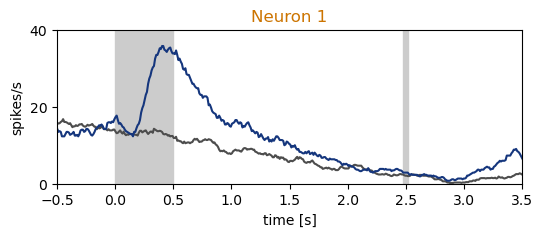

In [11]:
plt.figure(figsize=(6, 2))
idx_sn = np.where((clasesxneurona_VPC[indice] >= 6) & (clasesxneurona_VPC[indice] <= 10) & (aciertosxneurona_VPC[indice] == 1))[0]
tasa_sn = tasas_de_disparo_VPC[indice][idx_sn]
plt.plot(t, np.mean(tasa_sn, axis=0), color="#4D4D4D")
idx_clases = np.where((clasesxneurona_VPC[indice] >= 1) & (clasesxneurona_VPC[indice] <= 5) & (aciertosxneurona_VPC[indice] == 1))[0]
tasa_clase = tasas_de_disparo_VPC[indice][idx_clases]
plt.plot(t, np.mean(tasa_clase, axis=0), color=color_tactil)
plt.title(f"Neuron {indice+1}", color = col[indice])
plt.xlabel("time [s]")
plt.ylabel("spikes/s")
plt.xlim(-0.5, 3.5)
ymin, ymax = 0, 40
ticks = [ymin, (ymin + ymax) / 2, ymax]
plt.ylim(ymin, ymax)
plt.yticks(ticks)
plt.axvspan(0, 0.5, color="#CCCCCC")
plt.axvspan(PU-0.02, PU+0.02, color="#CCCCCC")
#plt.savefig(f"S5 Neuron {indice + 1} Firing Rate.svg")
plt.show()  

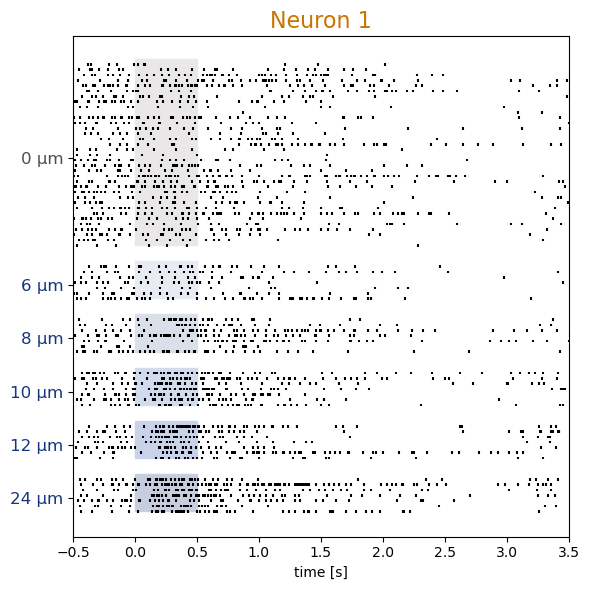

In [12]:
colores = ["#4D4D4D", "#15367D", "#15367D", "#15367D", "#15367D", "#15367D"]
etiquetas = ["0 μm", "6 μm", "8 μm", "10 μm", "12 μm", "24 μm"]
col_bloq = ["#E9E7E7", "#E8EBF1", "#DAE0EA", "#D2DBED", "#C8D3EA", "#C5CDDF"]
sep_bloques = 3
offsets, centros = [], []
start = 0
for bloque in bloques:
    n = len(bloque)
    idxs = np.arange(start, start + n)
    offsets.append(idxs)
    centros.append(start + n / 2)
    start += n + sep_bloques
all_data = [trial for bloque in bloques for trial in bloque]
all_offsets = np.concatenate(offsets)
fig, ax = plt.subplots(figsize=(6, 6))
x0, x1 = 0, 0.5
y_start = 0
for i, bloque in enumerate(bloques):
    n = len(bloque)
    y_bottom = y_start - 1
    y_top = y_start + n - 1
    rect = plt.Rectangle(
        (x0, y_bottom),
        x1 - x0,
        y_top - y_bottom,
        color=col_bloq[i],
        zorder=0
    )
    ax.add_patch(rect)
    y_start += n + sep_bloques
ax.eventplot(all_data, lineoffsets=all_offsets, linelengths=0.5, color="k", zorder=2)
ax.set_yticks(centros)
ax.set_yticklabels(etiquetas, fontsize=12)
for label, color in zip(ax.get_yticklabels(), colores):
    label.set_color(color)
ax.set_xlabel("time [s]")
ax.set_title(f"Neuron {indice + 1}", color=col[indice], fontsize=16)
ax.invert_yaxis()
plt.xlim(-0.5, 3.5)
plt.tight_layout()
#plt.savefig(f"S5 Neuron {indice + 1} Raster.svg")
plt.show()

In [13]:
indice = 1
neurona = neuronas_VPC[indice]
bloques = []
ensayos_sn = []
for i in [6, 7, 8, 9, 10, 5, 4, 3, 2, 1]:
    if i >= 6 and i <= 10:
        idx_sn = np.where((clasesxneurona_VPC[indice] == i) & (aciertosxneurona_VPC[indice] == 1))[0]
        if len(idx_sn) < 7:
            idx_sn_err = np.where((clasesxneurona_VPC[indice] == i) & (aciertosxneurona_VPC[indice] == 0))[0]
            idx_sn = np.concatenate((idx_sn, idx_sn_err))
            idx_sn = idx_sn[:7]
        else:
            idx_sn = idx_sn[:7]
        for j in idx_sn:
            ensayos_sn.append(neurona[j])
        if i == 10:
            bloques.append(ensayos_sn)
    else:
        ensayos_tac = []
        idx_sn = np.where((clasesxneurona_VPC[indice] == i) & (aciertosxneurona_VPC[indice] == 1))[0]
        if len(idx_sn) < 7:
            idx_sn_err = np.where((clasesxneurona_VPC[indice] == i) & (aciertosxneurona_VPC[indice] == 0))[0]
            idx_sn = np.concatenate((idx_sn, idx_sn_err))
            idx_sn = idx_sn[:7]
        else:
            idx_sn = idx_sn[:7]
        for j in idx_sn:
            ensayos_tac.append(neurona[j])
        bloques.append(ensayos_tac)

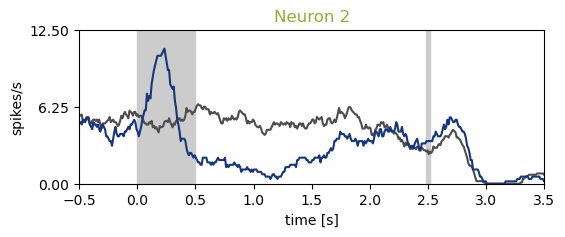

In [14]:
plt.figure(figsize=(6, 2))
idx_sn = np.where((clasesxneurona_VPC[indice] >= 6) & (clasesxneurona_VPC[indice] <= 10) & (aciertosxneurona_VPC[indice] == 1))[0]
tasa_sn = tasas_de_disparo_VPC[indice][idx_sn]
plt.plot(t, np.mean(tasa_sn, axis=0), color="#4D4D4D")
idx_clases = np.where((clasesxneurona_VPC[indice] >= 1) & (clasesxneurona_VPC[indice] <= 5) & (aciertosxneurona_VPC[indice] == 1))[0]
tasa_clase = tasas_de_disparo_VPC[indice][idx_clases]
plt.plot(t, np.mean(tasa_clase, axis=0), color=color_tactil)
plt.title(f"Neuron {indice+1}", color = col[indice])
plt.xlabel("time [s]")
plt.ylabel("spikes/s")
plt.xlim(-0.5, 3.5)
ymin, ymax = 0, 12.5
ticks = [ymin, (ymin + ymax) / 2, ymax]
plt.ylim(ymin, ymax)
plt.yticks(ticks)
plt.axvspan(0, 0.5, color="#CCCCCC")
plt.axvspan(PU-0.02, PU+0.02, color="#CCCCCC")
#plt.savefig(f"S5 Neuron {indice + 1} Firing Rate.svg")
plt.show()  

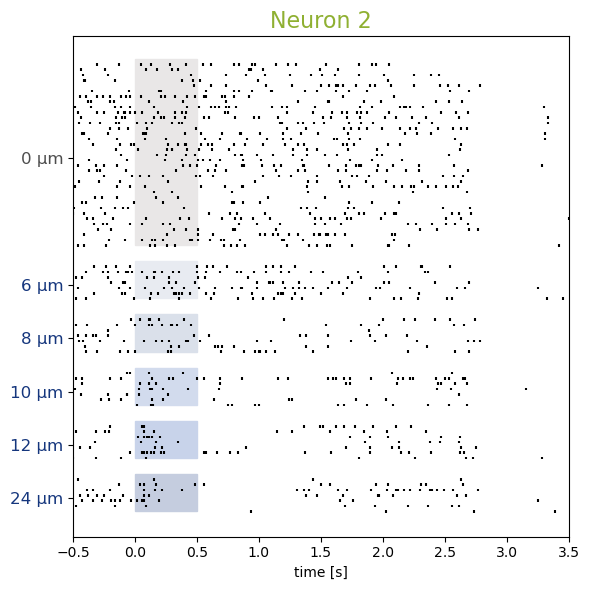

In [15]:
sep_bloques = 3
offsets, centros = [], []
start = 0
for bloque in bloques:
    n = len(bloque)
    idxs = np.arange(start, start + n)
    offsets.append(idxs)
    centros.append(start + n / 2)
    start += n + sep_bloques
all_data = [trial for bloque in bloques for trial in bloque]
all_offsets = np.concatenate(offsets)
fig, ax = plt.subplots(figsize=(6, 6))
x0, x1 = 0, 0.5
y_start = 0
for i, bloque in enumerate(bloques):
    n = len(bloque)
    y_bottom = y_start - 1
    y_top = y_start + n - 1
    rect = plt.Rectangle(
        (x0, y_bottom),
        x1 - x0,
        y_top - y_bottom,
        color=col_bloq[i],
        zorder=0
    )
    ax.add_patch(rect)
    y_start += n + sep_bloques
ax.eventplot(all_data, lineoffsets=all_offsets, linelengths=0.5, color="k", zorder=2)
ax.set_yticks(centros)
ax.set_yticklabels(etiquetas, fontsize=12)
for label, color in zip(ax.get_yticklabels(), colores):
    label.set_color(color)
ax.set_xlabel("time [s]")
ax.set_title(f"Neuron {indice + 1}", color=col[indice], fontsize=16)
ax.invert_yaxis()
plt.xlim(-0.5, 3.5)
plt.tight_layout()
#plt.savefig(f"S5 Neuron {indice + 1} Raster.svg")
plt.show()

In [16]:
indice = 2
neurona = neuronas_VPC[indice]
bloques = []
ensayos_sn = []
for i in [6, 7, 8, 9, 10, 5, 4, 3, 2, 1]:
    if i >= 6 and i <= 10:
        idx_sn = np.where((clasesxneurona_VPC[indice] == i) & (aciertosxneurona_VPC[indice] == 1))[0]
        if len(idx_sn) < 7:
            idx_sn_err = np.where((clasesxneurona_VPC[indice] == i) & (aciertosxneurona_VPC[indice] == 0))[0]
            idx_sn = np.concatenate((idx_sn, idx_sn_err))
            idx_sn = idx_sn[:7]
        else:
            idx_sn = idx_sn[:7]
        for j in idx_sn:
            ensayos_sn.append(neurona[j])
        if i == 10:
            bloques.append(ensayos_sn)
    else:
        ensayos_tac = []
        idx_sn = np.where((clasesxneurona_VPC[indice] == i) & (aciertosxneurona_VPC[indice] == 1))[0]
        if len(idx_sn) < 7:
            idx_sn_err = np.where((clasesxneurona_VPC[indice] == i) & (aciertosxneurona_VPC[indice] == 0))[0]
            idx_sn = np.concatenate((idx_sn, idx_sn_err))
            idx_sn = idx_sn[:7]
        else:
            idx_sn = idx_sn[:7]
        for j in idx_sn:
            ensayos_tac.append(neurona[j])
        bloques.append(ensayos_tac)

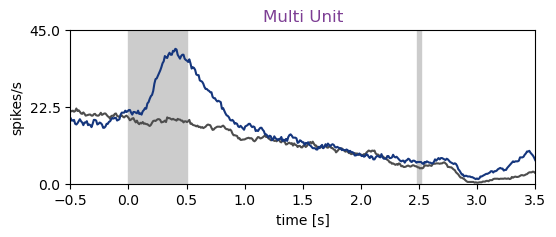

In [17]:
plt.figure(figsize=(6, 2))
idx_sn = np.where((clasesxneurona_VPC[indice] >= 6) & (clasesxneurona_VPC[indice] <= 10) & (aciertosxneurona_VPC[indice] == 1))[0]
tasa_sn = tasas_de_disparo_VPC[indice][idx_sn]
plt.plot(t, np.mean(tasa_sn, axis=0), color="#4D4D4D")
idx_clases = np.where((clasesxneurona_VPC[indice] >= 1) & (clasesxneurona_VPC[indice] <= 5) & (aciertosxneurona_VPC[indice] == 1))[0]
tasa_clase = tasas_de_disparo_VPC[indice][idx_clases]
plt.plot(t, np.mean(tasa_clase, axis=0), color=color_tactil)
plt.title(f"Multi Unit", color = col[indice])
plt.ylabel("spikes/s")
plt.xlim(-0.5, 3.5)
ymin, ymax = 0, 45
ticks = [ymin, (ymin + ymax) / 2, ymax]
plt.ylim(ymin, ymax)
plt.yticks(ticks)
plt.axvspan(0, 0.5, color="#CCCCCC")
plt.axvspan(PU-0.02, PU+0.02, color="#CCCCCC")
plt.xlabel("time [s]")
#plt.savefig(f"S5 Multi Unit Firing Rate.svg")
plt.show()  

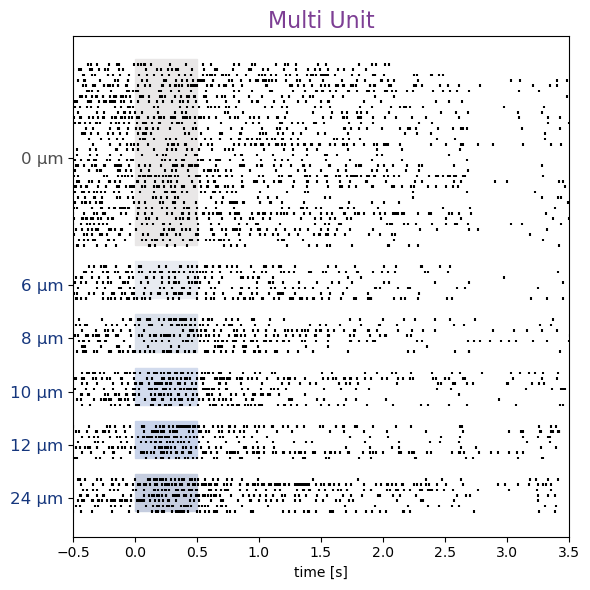

In [18]:
sep_bloques = 3
offsets, centros = [], []
start = 0
for bloque in bloques:
    n = len(bloque)
    idxs = np.arange(start, start + n)
    offsets.append(idxs)
    centros.append(start + n / 2)
    start += n + sep_bloques
all_data = [trial for bloque in bloques for trial in bloque]
all_offsets = np.concatenate(offsets)
fig, ax = plt.subplots(figsize=(6, 6))
x0, x1 = 0, 0.5
y_start = 0
for i, bloque in enumerate(bloques):
    n = len(bloque)
    y_bottom = y_start - 1
    y_top = y_start + n - 1
    rect = plt.Rectangle(
        (x0, y_bottom),
        x1 - x0,
        y_top - y_bottom,
        color=col_bloq[i],
        zorder=0
    )
    ax.add_patch(rect)
    y_start += n + sep_bloques
ax.eventplot(all_data, lineoffsets=all_offsets, linelengths=0.5, color="k", zorder=2)
ax.set_yticks(centros)
ax.set_yticklabels(etiquetas, fontsize=12)
for label, color in zip(ax.get_yticklabels(), colores):
    label.set_color(color)
ax.set_xlabel("time [s]")
ax.set_title(f"Multi Unit", color=col[indice], fontsize=16)
ax.invert_yaxis()
plt.xlim(-0.5, 3.5)
plt.tight_layout()
#plt.savefig(f"S5 Multi Unit Raster.svg")
plt.show()